# Main Idia: 

Find the biggest group of people that can imporve thier overall score (health) the most by improving one aspect of their lives by 1 point only: work-stress / workout / weight. than we can tell the company what should they focuse on and in which level.  

one point in weight = 5%

### How? 

start with clustering (using KMeans) to the best clustering num of groups.
than for each cluster check the av. health score. 
change 1 things only (a time) for each person in each cluster and check again what is the overall health score of this group. 

gett the group who changed the most by doing only 1 thing, get its attibutes and letting the company know.

#### Example please: 
letting the company know that young females that have high bmi that are usually practice only 1 time a week, if they will increase their working out level to 2 times (only by one practice a week) they will increase thier health by 34% in avarage. 

This kind of people are 20% of the company. 


In [169]:
import scipy
import numpy as np
import matplotlib
import pandas as pd
import collections


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



import os
import math
import seaborn
import matplotlib.pyplot as plt
import mpl_toolkits
import mpl_toolkits.mplot3d

In [170]:
## just a quick code to check what are the medians in blood_test_score, age and us_test_score. 
input_file="PreSee.csv"

def get_df(file):
    dataset = pd.read_csv(file)
    df = pd.DataFrame(dataset)
    df=df.fillna(0)
    return df
df=get_df(input_file)

def standart_dev(df, col):
    print(df[col].describe()) 

standart_dev(df, "blood_test_score")
print ("--------------")
standart_dev(df, "age")
print ("--------------")
standart_dev(df, "us_test_score")


count    1359.000000
mean       83.320088
std         9.313385
min        39.000000
25%        79.000000
50%        87.000000
75%        90.000000
max       101.000000
Name: blood_test_score, dtype: float64
--------------
count    1359.000000
mean       38.015453
std         9.200863
min         4.000000
25%        31.000000
50%        37.000000
75%        44.000000
max        82.000000
Name: age, dtype: float64
--------------
count    1359.000000
mean       97.317145
std        11.337191
min        36.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: us_test_score, dtype: float64


## DATA CLEANING

### modifide the table in xcel: 

changed values to numeric values: 
female = 1 , male = 0
Yes = 1 , NO = 0

added columns for making results in 1 / 0: 

bmi_bit  = IF(AND(bmi>18.5,bmi<25),1,0) meaining if good than 1 else 0;
acg_core_bit = IF(acd=100,1,0) meaining if was 100 than 1 else 0; (more than 75% got 100)
us_test_score_bit = IF(us_test_score>=60, 1, 0) 1 above median score , 0 less. 
blood_test_score_bit = =IF(blood_test_score>=87, 1, 0) ## if over or less than median. 
bp_systolic_bit =  IF(bp_systolic > 125, 0, 1) ## to hign by check medicine articles. 
bp_diastolic_bit = IF(AE2<=80, 1, 0) ## to low by check medicine articles. 

In [171]:
input_file="PreSeeNormFilterd.csv"

In [172]:
def get_df(file):
    dataset = pd.read_csv(file)
    df = pd.DataFrame(dataset)
    df=df.fillna(0)
    return df
original_df=get_df(input_file)

In [173]:
original_df

patient_id    gender  gender_norm        age  age_norm  height_cm  \
0            1.0  1.000000     1.313968  41.000000  0.365088      170.0   
1            2.0  0.000000    -0.760465  26.000000 -1.336637      173.0   
2            3.0  0.000000    -0.760465  38.000000  0.024743      172.0   
3            4.0  1.000000     1.313968  39.000000  0.138191      160.0   
4            5.0  0.000000    -0.760465  33.000000 -0.542499      176.0   
...          ...       ...          ...        ...       ...        ...   
1290      1357.0  1.000000     1.313968  36.000000 -0.202154      160.0   
1291      1358.0  0.000000    -0.760465  27.000000 -1.223188      169.0   
1292      1359.0  0.000000    -0.760465  32.000000 -0.655947      176.0   
1293         0.0  0.366589     0.000000  37.781903  0.000000        0.0   
1294         0.0  0.482059     0.000000   8.814589  0.000000        0.0   

      weight_kg        bmi  bmi_norm  ecg_test_score  ...  diabetes_factor  \
0          52.0  18.000000 -1.727775      100.000000  ...              2.0   
1          60.0  20.000000 -1.194470      100.000000  ...              2.0   
2          65.0  22.000000 -0.661166      100.000000  ...              2.0   
3          67.0  26.000000  0.405443      100.000000  ...              2.0   
4          79.0  26.000000  0.405443      100.000000  ...              2.0   
...         ...        ...       ...             ...  ...              ...   
1290       51.0  20.000000 -1.194470      100.000000  ...              2.0   
1291       88.0  31.000000  1.738705      100.000000  ...              2.0   
1292       77.0  25.000000  0.138791      100.000000  ...              2.0   
1293        0.0  24.479505  0.000000       96.751740  ...              0.0   
1294        0.0   3.750202  0.000000       13.582602  ...              0.0   

     diabetes_norm  work_stress_level  stress_norm  exercise_level  \
0         0.055685           0.400000    -0.645188        0.800000   
1         0.055685           0.400000    -0.645188        0.200000   
2         0.055685           0.400000    -0.645188        0.800000   
3         0.055685           0.800000     1.430007        0.600000   
4         0.055685           0.400000    -0.645188        0.600000   
...            ...                ...          ...             ...   
1290      0.055685           0.600000     0.392409        0.200000   
1291      0.055685           0.600000     0.392409        0.400000   
1292      0.055685           0.600000     0.392409        0.400000   
1293      0.000000           0.524362     0.000000        0.552359   
1294      0.000000           0.192753     0.000000        0.252457   

     exercies_norm  bp_systolic  bp_sys_norm bp_diastolic  bp_di_norm  
0         0.980922   112.000000    -0.517110    75.000000   -0.209134  
1        -1.395716   128.000000     0.574966    84.000000    0.677458  
2         0.980922   117.000000    -0.175837    79.000000    0.184907  
3         0.188710    96.000000    -1.609187    61.000000   -1.588277  
4         0.188710   117.000000    -0.175837    76.000000   -0.110624  
...            ...          ...          ...          ...         ...  
1290     -1.395716   133.000000     0.916240    85.000000    0.775968  
1291     -0.603503   118.000000    -0.107582    81.000000    0.381927  
1292     -0.603503   122.000000     0.165437    73.000000   -0.406155  
1293      0.000000   119.576179     0.000000    77.122970    0.000000  
1294      0.000000    14.650990     0.000000    10.151234    0.000000  

[1295 rows x 43 columns]

In [174]:
##Cleaning table to just be with relevant columns to our model. (withput changable things)

df = original_df[["gender", "bmi_norm", "acg_norm" ,  "us_norm", "blood_norm" , "heart_hist_factor" , "family_hist_norm", "bp_med_norm_half", "diabetes_factor", "bp_sys_norm" ,"bp_di_norm"  ]]
df

gender  bmi_norm  acg_norm   us_norm  blood_norm  heart_hist_factor  \
0     1.000000 -1.727775  0.239149  0.221099    1.591687                3.0   
1     0.000000 -1.194470  0.239149  0.221099    0.715967                3.0   
2     0.000000 -0.661166  0.239149  0.221099    0.059177                3.0   
3     1.000000  0.405443  0.239149  0.221099    0.825432                3.0   
4     0.000000  0.405443  0.239149  0.221099   -1.801728                3.0   
...        ...       ...       ...       ...         ...                ...   
1290  1.000000 -1.194470  0.239149  0.221099    0.934897                3.0   
1291  0.000000  1.738705  0.239149  0.221099   -0.050288                3.0   
1292  0.000000  0.138791  0.239149  0.221099    0.387572                3.0   
1293  0.366589  0.000000  0.000000  0.000000    0.000000                0.0   
1294  0.482059  0.000000  0.000000  0.000000    0.000000                0.0   

      family_hist_norm  bp_med_norm_half  diabetes_factor  bp_sys_norm  \
0             0.356637          0.088143              2.0    -0.517110   
1            -2.801801          0.088143              2.0     0.574966   
2             0.356637          0.088143              2.0    -0.175837   
3             0.356637          0.088143              2.0    -1.609187   
4             0.356637          0.088143              2.0    -0.175837   
...                ...               ...              ...          ...   
1290         -2.801801          0.088143              2.0     0.916240   
1291          0.356637          0.088143              2.0    -0.107582   
1292          0.356637          0.088143              2.0     0.165437   
1293          0.000000          0.000000              0.0     0.000000   
1294          0.000000          0.000000              0.0     0.000000   

      bp_di_norm  
0      -0.209134  
1       0.677458  
2       0.184907  
3      -1.588277  
4      -0.110624  
...          ...  
1290    0.775968  
1291    0.381927  
1292   -0.406155  
1293    0.000000  
1294    0.000000  

[1295 rows x 11 columns]

In [175]:
##creating male df
df_male = df[df["gender"] == 0];
df_male


gender  bmi_norm  acg_norm   us_norm  blood_norm  heart_hist_factor  \
1        0.0 -1.194470  0.239149  0.221099    0.715967                3.0   
2        0.0 -0.661166  0.239149  0.221099    0.059177                3.0   
4        0.0  0.405443  0.239149  0.221099   -1.801728                3.0   
5        0.0 -0.394513  0.239149 -3.899035   -0.816543                3.0   
6        0.0 -0.127861  0.239149  0.221099   -0.378683                3.0   
...      ...       ...       ...       ...         ...                ...   
1287     0.0 -0.394513  0.239149  0.221099    0.606502                3.0   
1288     0.0 -1.461123  0.239149  0.221099    0.606502                3.0   
1289     0.0 -0.127861  0.239149  0.221099    0.387572                3.0   
1291     0.0  1.738705  0.239149  0.221099   -0.050288                3.0   
1292     0.0  0.138791  0.239149  0.221099    0.387572                3.0   

      family_hist_norm  bp_med_norm_half  diabetes_factor  bp_sys_norm  \
1            -2.801801          0.088143              2.0     0.574966   
2             0.356637          0.088143              2.0    -0.175837   
4             0.356637          0.088143              2.0    -0.175837   
5            -2.801801          0.088143              2.0     0.711476   
6             0.356637          0.088143              2.0     0.643221   
...                ...               ...              ...          ...   
1287          0.356637          0.088143              2.0    -0.175837   
1288          0.356637          0.088143              2.0    -0.107582   
1289         -2.801801          0.088143              2.0    -0.926639   
1291          0.356637          0.088143              2.0    -0.107582   
1292          0.356637          0.088143              2.0     0.165437   

      bp_di_norm  
1       0.677458  
2       0.184907  
4      -0.110624  
5       0.381927  
6       0.972988  
...          ...  
1287   -0.209134  
1288   -0.406155  
1289    0.381927  
1291    0.381927  
1292   -0.406155  

[819 rows x 11 columns]

In [176]:
## creating female df

df_female = df[df["gender"] == 1];
df_female

gender  bmi_norm  acg_norm   us_norm  blood_norm  heart_hist_factor  \
0        1.0 -1.727775  0.239149  0.221099    1.591687                3.0   
3        1.0  0.405443  0.239149  0.221099    0.825432                3.0   
9        1.0 -0.661166  0.239149  0.221099   -0.707078                3.0   
15       1.0  0.138791  0.239149  0.221099    0.606502                3.0   
16       1.0  0.938748  0.239149  0.221099   -2.567983                3.0   
...      ...       ...       ...       ...         ...                ...   
1276     1.0  0.138791  0.239149  0.221099   -0.707078                3.0   
1278     1.0 -1.994427  0.239149  0.221099    0.715967                3.0   
1281     1.0 -1.194470  0.239149  0.221099    0.387572                3.0   
1282     1.0 -1.994427  0.239149  0.221099    0.606502                3.0   
1290     1.0 -1.194470  0.239149  0.221099    0.934897                3.0   

      family_hist_norm  bp_med_norm_half  diabetes_factor  bp_sys_norm  \
0             0.356637          0.088143              2.0    -0.517110   
3             0.356637          0.088143              2.0    -1.609187   
9             0.356637          0.088143              2.0    -0.585365   
15           -2.801801          0.088143              2.0     2.213081   
16            0.356637          0.088143              2.0    -0.039327   
...                ...               ...              ...          ...   
1276          0.356637          0.088143              2.0    -0.312346   
1278          0.356637          0.088143              2.0    -0.312346   
1281          0.356637         -2.834121              2.0    -0.653620   
1282          0.356637          0.088143              2.0    -1.336168   
1290         -2.801801          0.088143              2.0     0.916240   

      bp_di_norm  
0      -0.209134  
3      -1.588277  
9      -0.701685  
15      1.958090  
16      0.283417  
...          ...  
1276   -0.603175  
1278   -0.701685  
1281   -0.307644  
1282   -0.307644  
1290    0.775968  

[474 rows x 11 columns]

## Choosing the right K:


In [187]:
distance_metric='euclidean'
k_range = np.arange(2, 10, 1)

In [188]:
# Build model function
def get_clusterer(points,k):
    clusterer = KMeans (n_clusters=k)
    preds = clusterer.fit_predict(points)
    return clusterer,preds

clusterer,preds=get_clusterer(df,5)
clusterer_male,preds_male=get_clusterer(df_male,1)
clusterer_female,preds_female=get_clusterer(df_female,1)


In [189]:
#bulding the model for each K in range 2 to 5. 
def get_silheuettes(df,preds):
    Silhouettes = []
    for k in k_range:
        clusterer,preds=get_clusterer(df,k)
        Silhouettes.append(silhouette_score (df, preds, metric='euclidean'))
    return Silhouettes

Silhouettes = get_silheuettes(df,preds)
Silhouettes_male = get_silheuettes(df_male,preds_male)
Silhouettes_female = get_silheuettes(df_female,preds_female)



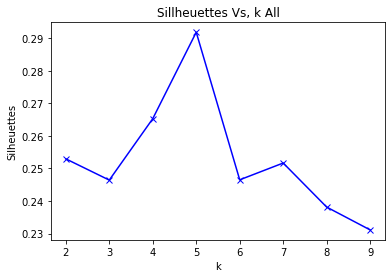

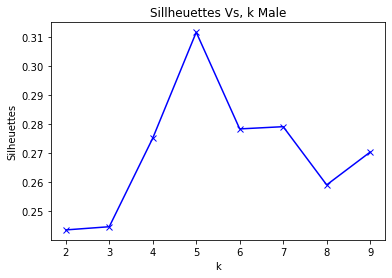

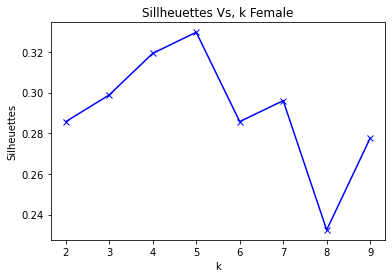

In [190]:
# plot the silhouttes results. 
def show_silhouettes (Silhouettes, str):
    plt.plot(k_range, Silhouettes, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silheuettes')
    plt.title('Sillheuettes Vs, k' + " " + str)
    plt.show()
    
    
show_silhouettes(Silhouettes, "All")
show_silhouettes(Silhouettes_male, "Male")
show_silhouettes(Silhouettes_female, "Female")



## Building The Model For Best K

In [191]:
# Build model for K=4
K=5
def get_clusterer(points,k):
    clusterer = KMeans (n_clusters=k)
    preds = clusterer.fit_predict(points)
    return clusterer,preds
clusterer,preds=get_clusterer(df,K)

In [192]:
def show_labels_results (clusterer):
    print('labels:', clusterer.labels_, '\n') 
#show_labels_results(clusterer)

print(len(clusterer.labels_))

## Trying to understand how many data points we have in each group and wether it have normal distribution or not.

labels = clusterer.labels_

collections.Counter(labels)




1295


Counter({1: 615, 3: 127, 0: 433, 4: 61, 2: 59})

centroids:
0 : [ 0.18706697  0.62344561  0.23914857  0.22109908 -0.54806293  2.94457275
  0.34934294 -0.03333726  2.          0.6982344   0.73478909] 

1 : [ 0.51032301 -0.50509435  0.23837085  0.22038005  0.43045375  2.95121951
  0.35547746  0.059346    1.9902439  -0.59578071 -0.59464601] 

2 : [ 2.88135593e-01  8.45568175e-02 -4.17826713e+00  2.21099075e-01
 -3.90439107e-03  2.89830508e+00  8.89730055e-02  8.81425340e-02
  2.00000000e+00  1.50398137e-01  1.24798681e-01] 

3 : [ 0.37795276 -0.07327089  0.23914857  0.22109907 -0.06063102  2.85826772
 -2.80180093 -0.04991718  1.96850394 -0.02965309 -0.03460823] 

4 : [ 0.24590164  0.73766604 -0.55743459 -4.4654764  -0.31946412  2.80327869
 -0.31647252 -0.34301117  1.96721311  0.96659171  0.73074992] 



gender  bmi_norm  acg_norm   us_norm  blood_norm  heart_hist_factor  \
0     1.000000 -1.727775  0.239149  0.221099    1.591687                3.0   
1     0.000000 -1.194470  0.239149  0.221099    0.715967                3.0   
2     0.000000 -0.661166  0.239149  0.221099    0.059177                3.0   
3     1.000000  0.405443  0.239149  0.221099    0.825432                3.0   
4     0.000000  0.405443  0.239149  0.221099   -1.801728                3.0   
...        ...       ...       ...       ...         ...                ...   
1290  1.000000 -1.194470  0.239149  0.221099    0.934897                3.0   
1291  0.000000  1.738705  0.239149  0.221099   -0.050288                3.0   
1292  0.000000  0.138791  0.239149  0.221099    0.387572                3.0   
1293  0.366589  0.000000  0.000000  0.000000    0.000000                0.0   
1294  0.482059  0.000000  0.000000  0.000000    0.000000                0.0   

      family_hist_norm  bp_med_norm_half  diabetes_factor  bp_sys_norm  \
0             0.356637          0.088143              2.0    -0.517110   
1            -2.801801          0.088143              2.0     0.574966   
2             0.356637          0.088143              2.0    -0.175837   
3             0.356637          0.088143              2.0    -1.609187   
4             0.356637          0.088143              2.0    -0.175837   
...                ...               ...              ...          ...   
1290         -2.801801          0.088143              2.0     0.916240   
1291          0.356637          0.088143              2.0    -0.107582   
1292          0.356637          0.088143              2.0     0.165437   
1293          0.000000          0.000000              0.0     0.000000   
1294          0.000000          0.000000              0.0     0.000000   

      bp_di_norm  
0      -0.209134  
1       0.677458  
2       0.184907  
3      -1.588277  
4      -0.110624  
...          ...  
1290    0.775968  
1291    0.381927  
1292   -0.406155  
1293    0.000000  
1294    0.000000  

[1295 rows x 11 columns]

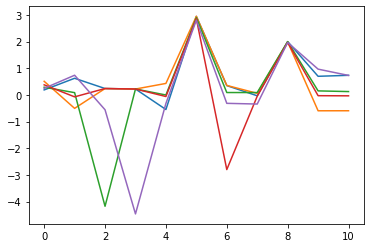

In [193]:
def show_results (clusterer):
    centers = clusterer.cluster_centers_
    print('centroids:')
    for i in range(K):
        print(i,':',centers[i,:],'\n')
    for i in range(K):
        plt.plot(centers[i,:])
show_results(clusterer)

df

# PART 3: Conclusions.

In this part we want to take the clusters that the Kmeans created and look at the columns that we didnt include in the algorithem. like : weight, smoking, work_stress_level, exercise level. and try to see if there are any differences between the groups, so we can know what field and which group should we be focusing more - so we can save more lifes. 


In [194]:
#df. insert(location, column_name, list_of_values)
new_df = original_df
new_df.insert(0, "Kmeans_label", labels)


In [243]:
def getSize(df, newdf):
    print('overall',df.shape[0]*100/newdf.shape[0], '% from all people')

In [244]:
new_df

Kmeans_label  patient_id    gender  gender_norm        age  age_norm  \
0                1         1.0  1.000000     1.313968  41.000000  0.365088   
1                3         2.0  0.000000    -0.760465  26.000000 -1.336637   
2                1         3.0  0.000000    -0.760465  38.000000  0.024743   
3                1         4.0  1.000000     1.313968  39.000000  0.138191   
4                0         5.0  0.000000    -0.760465  33.000000 -0.542499   
...            ...         ...       ...          ...        ...       ...   
1290             3      1357.0  1.000000     1.313968  36.000000 -0.202154   
1291             0      1358.0  0.000000    -0.760465  27.000000 -1.223188   
1292             1      1359.0  0.000000    -0.760465  32.000000 -0.655947   
1293             1         0.0  0.366589     0.000000  37.781903  0.000000   
1294             1         0.0  0.482059     0.000000   8.814589  0.000000   

      height_cm  weight_kg        bmi  bmi_norm  ...  diabetes_factor  \
0         170.0       52.0  18.000000 -1.727775  ...              2.0   
1         173.0       60.0  20.000000 -1.194470  ...              2.0   
2         172.0       65.0  22.000000 -0.661166  ...              2.0   
3         160.0       67.0  26.000000  0.405443  ...              2.0   
4         176.0       79.0  26.000000  0.405443  ...              2.0   
...         ...        ...        ...       ...  ...              ...   
1290      160.0       51.0  20.000000 -1.194470  ...              2.0   
1291      169.0       88.0  31.000000  1.738705  ...              2.0   
1292      176.0       77.0  25.000000  0.138791  ...              2.0   
1293        0.0        0.0  24.479505  0.000000  ...              0.0   
1294        0.0        0.0   3.750202  0.000000  ...              0.0   

      diabetes_norm work_stress_level  stress_norm  exercise_level  \
0          0.055685          0.400000    -0.645188        0.800000   
1          0.055685          0.400000    -0.645188        0.200000   
2          0.055685          0.400000    -0.645188        0.800000   
3          0.055685          0.800000     1.430007        0.600000   
4          0.055685          0.400000    -0.645188        0.600000   
...             ...               ...          ...             ...   
1290       0.055685          0.600000     0.392409        0.200000   
1291       0.055685          0.600000     0.392409        0.400000   
1292       0.055685          0.600000     0.392409        0.400000   
1293       0.000000          0.524362     0.000000        0.552359   
1294       0.000000          0.192753     0.000000        0.252457   

      exercies_norm bp_systolic  bp_sys_norm  bp_diastolic bp_di_norm  
0          0.980922  112.000000    -0.517110     75.000000  -0.209134  
1         -1.395716  128.000000     0.574966     84.000000   0.677458  
2          0.980922  117.000000    -0.175837     79.000000   0.184907  
3          0.188710   96.000000    -1.609187     61.000000  -1.588277  
4          0.188710  117.000000    -0.175837     76.000000  -0.110624  
...             ...         ...          ...           ...        ...  
1290      -1.395716  133.000000     0.916240     85.000000   0.775968  
1291      -0.603503  118.000000    -0.107582     81.000000   0.381927  
1292      -0.603503  122.000000     0.165437     73.000000  -0.406155  
1293       0.000000  119.576179     0.000000     77.122970   0.000000  
1294       0.000000   14.650990     0.000000     10.151234   0.000000  

[1295 rows x 44 columns]

In [245]:
 # family hist.
df_c3 = new_df[new_df["Kmeans_label"] == 3];
df_c3 = df_c3[['age', 'weight_kg','bp_medication' ,'smoking' ,'work_stress_level', "exercise_level",  "bp_med_norm_half", "diabetes", "bp_sys_norm" ,"bp_di_norm"  ]]
print(" --------- family hist ------------")
getSize(df_c3, new_df)

## low US score
df_c4 = new_df[new_df["Kmeans_label"] == 4];
df_c4 = df_c4[['age', 'weight_kg','bp_medication' ,'smoking' ,'work_stress_level', "exercise_level",  "bp_med_norm_half", "diabetes", "bp_sys_norm" ,"bp_di_norm"  ]]
print(" --------- low US score ------------")
getSize(df_c4, new_df)



## low ECG score
df_c2 = new_df[new_df["Kmeans_label"] == 2];
df_c2 = df_c2[['age', 'weight_kg','bp_medication' ,'smoking' ,'work_stress_level', "exercise_level",  "bp_med_norm_half", "diabetes", "bp_sys_norm" ,"bp_di_norm"  ]]
print(" --------- low ECG score ------------")
getSize(df_c2, new_df)

## low ECG score
df_others = new_df[new_df["Kmeans_label"] <= 1];
df_others = df_others[['age', 'weight_kg','bp_medication' ,'smoking' ,'work_stress_level', "exercise_level",  "bp_med_norm_half", "diabetes", "bp_sys_norm" ,"bp_di_norm"  ]]


print(" --------- others ------------")
getSize(df_others, new_df)




 --------- family hist ------------
overall 9.806949806949808 % from all people
 --------- low US score ------------
overall 4.710424710424711 % from all people
 --------- low ECG score ------------
overall 4.555984555984556 % from all people
 --------- others ------------
overall 80.92664092664093 % from all people


 --------- family hist ------------
7 numbers statistics
               age   weight_kg  bp_medication     smoking  work_stress_level  \
count  127.000000  127.000000     127.000000  127.000000         127.000000   
mean    38.322835   72.984252       0.952756    0.803150           0.524409   
std      8.748589   14.877801       0.213001    0.399193           0.209200   
min     21.000000   43.000000       0.000000    0.000000           0.000000   
25%     31.500000   63.000000       1.000000    1.000000           0.400000   
50%     37.000000   72.000000       1.000000    1.000000           0.600000   
75%     44.500000   84.500000       1.000000    1.000000           0.600000   
max     60.000000  110.000000       1.000000    1.000000           1.000000   

       exercise_level  bp_med_norm_half    diabetes  bp_sys_norm  bp_di_norm  
count      127.000000        127.000000  127.000000   127.000000  127.000000  
mean         0.537008         -0.049917    0.984252    -0.029653   -0.03

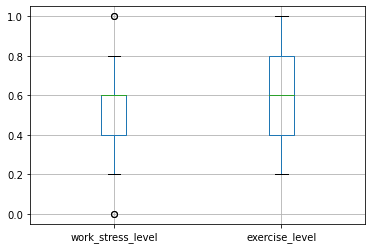

In [235]:
#19. Using a Box & Whisker plot on the Quantity data, what represents the vertical line below the box, 
#the vertical line above the box and the vertical line which goes through the box?


def plot_statistics(dataframe,selected_columns):
    print('7 numbers statistics\n',dataframe.describe())
    
    #print('Box and Whisker\n',dataframe.boxplot())
    print('Box and Whisker for selected columns\n',dataframe.boxplot(column=selected_columns) ) 


print(" --------- family hist ------------")    
plot_statistics(df_c3,['work_stress_level', 'exercise_level'])




 --------- low US score ------------
7 numbers statistics
              age   weight_kg  bp_medication    smoking  work_stress_level  \
count  61.000000   61.000000      61.000000  61.000000          61.000000   
mean   49.147541   80.983607       0.852459   0.885246           0.491803   
std     8.481030   15.355229       0.357588   0.321370           0.205179   
min    30.000000   48.000000       0.000000   0.000000           0.000000   
25%    42.000000   70.000000       1.000000   1.000000           0.400000   
50%    48.000000   82.000000       1.000000   1.000000           0.600000   
75%    56.000000   90.000000       1.000000   1.000000           0.600000   
max    65.000000  125.000000       1.000000   1.000000           1.000000   

       exercise_level  bp_med_norm_half   diabetes  bp_sys_norm  bp_di_norm  
count       61.000000         61.000000  61.000000    61.000000   61.000000  
mean         0.603279         -0.343011   0.983607     0.966592    0.730750  
std          

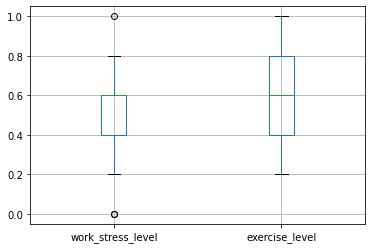

In [236]:
print(" --------- low US score ------------")
plot_statistics(df_c4,['work_stress_level', 'exercise_level'])

#older people. 
#practice like avg. 
#work stress level meadinan 3/5 but avg 0.5 ike everyone. 

 --------- low ECG score ------------
7 numbers statistics
              age   weight_kg  bp_medication    smoking  work_stress_level  \
count  59.000000   59.000000           59.0  59.000000          59.000000   
mean   39.186441   74.932203            1.0   0.745763           0.535593   
std     9.631977   14.138312            0.0   0.439169           0.239081   
min    24.000000   49.000000            1.0   0.000000           0.000000   
25%    31.000000   65.500000            1.0   0.500000           0.400000   
50%    38.000000   75.000000            1.0   1.000000           0.600000   
75%    46.000000   84.000000            1.0   1.000000           0.600000   
max    64.000000  107.000000            1.0   1.000000           1.000000   

       exercise_level  bp_med_norm_half  diabetes  bp_sys_norm  bp_di_norm  
count       59.000000      5.900000e+01      59.0    59.000000   59.000000  
mean         0.572881      8.814253e-02       1.0     0.150398    0.124799  
std          0.

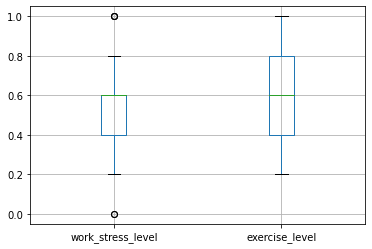

In [237]:
print(" --------- low ECG score ------------")
plot_statistics(df_c2,['work_stress_level', 'exercise_level'])

 --------- Others ------------
7 numbers statistics
                age    weight_kg  bp_medication      smoking  \
count  1048.000000  1048.000000    1048.000000  1048.000000   
mean     36.948088    72.666985       0.976280     0.863747   
std       8.356960    14.719627       0.151712     0.342728   
min       8.814589     0.000000       0.000000     0.000000   
25%      31.000000    62.000000       1.000000     1.000000   
50%      36.000000    72.000000       1.000000     1.000000   
75%      42.000000    83.000000       1.000000     1.000000   
max      65.000000   125.000000       1.000000     1.000000   

       work_stress_level  exercise_level  bp_med_norm_half     diabetes  \
count        1048.000000     1048.000000       1048.000000  1048.000000   
mean            0.525303        0.549814          0.021052     0.998142   
std             0.187183        0.252445          0.437333     0.042469   
min             0.000000        0.200000         -2.834121     0.000000   
25% 

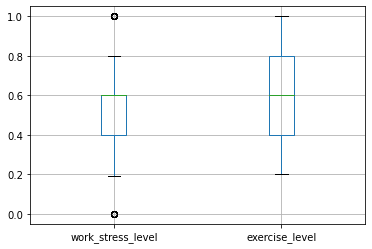

In [238]:
print(" --------- Others ------------")
plot_statistics(df_others,['work_stress_level', 'exercise_level'])



# Problems: 
1. it looks like that doesnt matter if we take the man / women / all table the clusters are geting better as we increase K. 
2. as we are making the K higher we are getting less equal ampunt of people in every cluster. (there are few clusters with a lot of people, and alot of other small clusters with a lot less people in). 
3. the clusters graph doesnt seem to be veryy different between another. (doesnt matter what K we choose and that df all / male / female. 

# Possible Solutions? 
1. we are not sure why it happends. is it becouse we did somthing to obviece in our pre-proccesing of the file? what can we do  different there? is there a way to tell the algorithem what is more important and what is less? is there a way for us to k ow what is more important and what is less (for example its quite clear that if you had hurt problems in the past it should be with more wight than have a littlbit high blood presure but we are not sure how to do that. 

2. should we try to choose the K with the best distribution? 

3. again? anything that we did with prepering the data?

4. we are open to hear any suggestions. 